In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [4]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

100% 427M/427M [00:06<00:00, 97.4MB/s]
100% 427M/427M [00:06<00:00, 72.7MB/s]


In [5]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

<ipython-input-5-4addd0ae159c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [6]:
from zipfile import ZipFile
file_name = "/content/diabetic-retinopathy-224x224-gaussian-filtered.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [7]:
!pip install imutils
import keras
import tensorflow
import os
from keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.layers import BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
from keras.models import Model
from sklearn.utils import shuffle
from cv2 import imread
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
data = []
labels = []
width,height=150,150

imagePaths = list(paths.list_images('/content/gaussian_filtered_images/gaussian_filtered_images'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    #print(imagePath)
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    if label in {'Mild', 'Proliferate_DR', 'Moderate', 'Severe'}:
        labels.append("DR")
    else:
        labels.append("No_DR")


data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#labels = to_categorical(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)
print(labels[500])

(3662, 150, 150, 3)
(3662, 1)
[0]


In [10]:
test_ratio = 0.2

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_ratio)

print("Train images:",X_train.shape)
print("Test images:",X_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (2929, 150, 150, 3)
Test images: (733, 150, 150, 3)
Train label: (2929, 1)
Test label: (733, 1)


In [11]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (2929, 150, 150, 3)
X_test Shape:  (733, 150, 150, 3)
y_train Shape:  (2929, 2)
y_test Shape:  (733, 2)


In [14]:
from keras.applications import vgg16


img_rows, img_cols = 150, 150 


vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [15]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [17]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [18]:
history = model.fit(X_train,y_train,
                    epochs=5, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
92/92 [==============================] - 865s 9s/step - loss: 0.6854 - accuracy: 0.9058 - val_loss: 0.1431 - val_accuracy: 0.9495
Epoch 2/5
92/92 [==============================] - 852s 9s/step - loss: 0.1531 - accuracy: 0.9512 - val_loss: 0.1319 - val_accuracy: 0.9577
Epoch 3/5
92/92 [==============================] - 852s 9s/step - loss: 0.1340 - accuracy: 0.9553 - val_loss: 0.1235 - val_accuracy: 0.9577
Epoch 4/5
92/92 [==============================] - 853s 9s/step - loss: 0.1212 - accuracy: 0.9573 - val_loss: 0.1500 - val_accuracy: 0.9563
Epoch 5/5
92/92 [==============================] - 855s 9s/step - loss: 0.1039 - accuracy: 0.9652 - val_loss: 0.1472 - val_accuracy: 0.9563


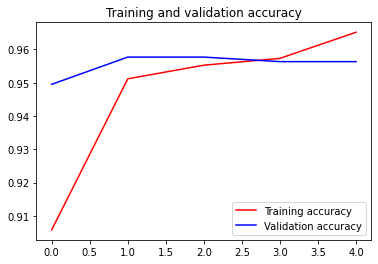

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()